<a href="https://colab.research.google.com/github/ShuaimingJing/XAI_assignment2/blob/main/Assignment2_Adversarial_patch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #2 Adversarial patch
# Shuaiming Jing




[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/12lNFBEuhaI22DWmNSNVtBZa7eUdI7x7I#scrollTo=0CELs8iFOb4q)

In [1]:
# Import necessary libraries
import torchvision
import torch
import torch.nn as nn
import numpy as np
import os
from tqdm import tqdm
import json
from torchvision import transforms
import torch.utils.data as data
import matplotlib.pyplot as plt
import urllib.request
from urllib.error import HTTPError
import zipfile





## Load model and datasets

In [2]:
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print('device:', device)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial10"
# Github URL where the dataset is stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"
# Files to download
pretrained_files = [(DATASET_PATH, "TinyImageNet.zip"), (CHECKPOINT_PATH, "patches.zip")]
# Create checkpoint path if it doesn't exist yet
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for dir_name, file_name in pretrained_files:
    file_path = os.path.join(dir_name, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong.", e)
        if file_name.endswith(".zip"):
            print("Unzipping file...")
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(file_path.rsplit("/",1)[0])

pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
pretrained_model = pretrained_model.to(device)


device: cuda:0
Unzipping file...
Unzipping file...


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 211MB/s]


In [3]:
# Mean and Std from ImageNet
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN,
                         std=NORM_STD)
])
# Load dataset and create data loader
imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
dataset = torchvision.datasets.ImageFolder(root=imagenet_path, transform=plain_transforms)
data_loader = data.DataLoader(dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=8)

TENSOR_MEANS, TENSOR_STD = torch.FloatTensor(NORM_MEAN)[:,None,None], torch.FloatTensor(NORM_STD)[:,None,None]
dataset = torchvision.datasets.ImageFolder(root=imagenet_path, transform=plain_transforms)
data_loader = data.DataLoader(dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=8)
# Load label names to interpret the label numbers 0 to 999
with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)



## Adversarial patch creation

Validation results for hen and 48: {'acc': 0.0}


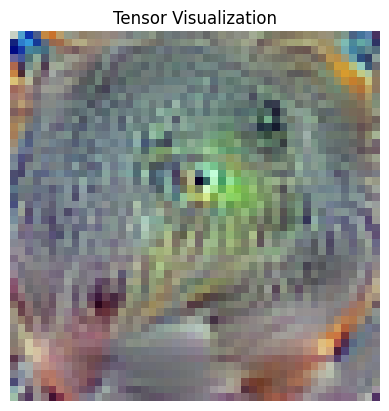

In [4]:
# Map patch values from [-infty,infty] to ImageNet min and max
def patch_forward(patch):
    patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
    return patch



# rotated and scaled the patch during training for robustness
def place_patch(img, patch):
    for i in range(img.shape[0]):
        h_offset = np.random.randint(0,img.shape[2]-patch.shape[1]-1)
        w_offset = np.random.randint(0,img.shape[3]-patch.shape[2]-1)
        img[i,:,h_offset:h_offset+patch.shape[1],w_offset:w_offset+patch.shape[2]] = patch_forward(patch)
    return img

def eval_patch(model, patch, val_loader, target_class):
    model.eval()
    tp, tp_5, counter = 0., 0., 0.
    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):
            # For stability, place the patch at 4 random locations per image, and average the performance
            for _ in range(4):
                patch_img = place_patch(img, patch)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)
                pred = model(patch_img)
                # In the accuracy calculation, we need to exclude the images that are of our target class
                # as we would not "fool" the model into predicting those
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class).sum()
                counter += (img_labels != target_class).sum()
    acc = tp/counter
    return acc

def patch_attack(model, target_class, patch_size=64, num_epochs=5):
    # Leave a small set of images out to check generalization
    train_set, val_set = torch.utils.data.random_split(dataset, [4500, 500])
    train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True, num_workers=8)
    val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)

    # Create parameter and optimizer
    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)
    patch = nn.Parameter(torch.zeros(3, patch_size[0], patch_size[1]), requires_grad=True)
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        for img, _ in t:
            img = place_patch(img, patch)
            img = img.to(device)
            pred = model(img)
            labels = torch.zeros(img.shape[0], device=pred.device, dtype=torch.long).fill_(target_class)
            loss = loss_module(pred, labels)
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            t.set_description(f"Epoch {epoch}, Loss: {loss.item():4.2f}")

    # Final validation
    acc = eval_patch(model, patch, val_loader, target_class)

    return patch.data, {"acc": acc.item()}

# Load evaluation results of the pretrained patches
json_results_file = os.path.join(CHECKPOINT_PATH, "patch_results.json")
json_results = {}
if os.path.isfile(json_results_file):
    with open(json_results_file, "r") as f:
        json_results = json.load(f)

def save_results(patch_dict):
    result_dict = {cname: {psize: [t.item() if isinstance(t, torch.Tensor) else t
                                   for t in patch_dict[cname][psize]["results"]]
                           for psize in patch_dict[cname]}
                   for cname in patch_dict}
    with open(os.path.join(CHECKPOINT_PATH, "patch_results.json"), "w") as f:
        json.dump(result_dict, f, indent=4)


def get_patches(class_names, patch_sizes):
    result_dict = dict()

    # Loop over all classes and patch sizes
    for name in class_names:
        result_dict[name] = dict()
        for patch_size in patch_sizes:
            c = label_names.index(name)
            file_name = os.path.join(CHECKPOINT_PATH, f"{name}_{patch_size}_patch.pt")
            # Load patch if pretrained file exists, otherwise start training
            if not os.path.isfile(file_name):
                patch, val_results = patch_attack(pretrained_model, target_class=c, patch_size=patch_size, num_epochs=5)
                print(f"Validation results for {name} and {patch_size}:", val_results)
                torch.save(patch, file_name)
            else:
                patch = torch.load(file_name)
            # Load evaluation results if exist, otherwise manually evaluate the patch
            if name in json_results:
                results = json_results[name][str(patch_size)]
            else:
                results = eval_patch(pretrained_model, patch, data_loader, target_class=c)

            # Store results and the patches in a dict for better access
            result_dict[name][patch_size] = {
                "results": results,
                "patch": patch
            }

    return result_dict

# def show_patches(patch_dict, class_names, patch_sizes):
#     # Create subplots with appropriate grid size
#     fig, ax = plt.subplots(len(patch_sizes), len(class_names),
#                            figsize=(len(class_names) * 2.2, len(patch_sizes) * 2.2))

#     # Ensure ax is always a 2D array
#     if len(class_names) == 1 and len(patch_sizes) == 1:
#         ax = np.array([[ax]])  # Make ax a 2D array if there's only one subplot
#     elif len(class_names) == 1:
#         ax = np.array(ax).reshape(len(patch_sizes), 1)  # Reshape into a column
#     elif len(patch_sizes) == 1:
#         ax = np.array(ax).reshape(1, len(class_names))  # Reshape into a row

#     # Iterate over classes and patch sizes to display each patch
#     for c_idx, cname in enumerate(class_names):
#         print(c_idx, cname)
#         for p_idx, psize in enumerate(patch_sizes):
#             patch = patch_dict[cname][psize]["patch"]
#             patch = (torch.tanh(patch) + 1) / 2  # Convert to pixel values [0, 1]
#             patch = patch.cpu().permute(1, 2, 0).numpy()
#             patch = np.clip(patch, a_min=0.0, a_max=1.0)
#             ax[p_idx][c_idx].imshow(patch)
#             ax[p_idx][c_idx].set_title(f"{cname}, size {psize}")
#             ax[p_idx][c_idx].axis('off')

#     # Adjust spacing between subplots
#     fig.subplots_adjust(hspace=0.3, wspace=0.3)
#     plt.show()

class_names = ['hen']
patch_sizes = [48]

patch_dict = get_patches(class_names, patch_sizes)
# show_patches(patch_dict, class_names, patch_sizes)

adversarial_patch_1 = patch_dict['hen'][48]['patch']

# Convert tensor to numpy and rearrange to Height x Width x Channels
image = adversarial_patch_1.permute(1, 2, 0).numpy()

# Normalize the values to the range [0, 1] for visualization
image = (image - image.min()) / (image.max() - image.min())

# Display the image
plt.imshow(image)
plt.title('Tensor Visualization')
plt.axis('off')  # Remove axis labels
plt.show()


## Rotate the adversarial tensor and combine the results

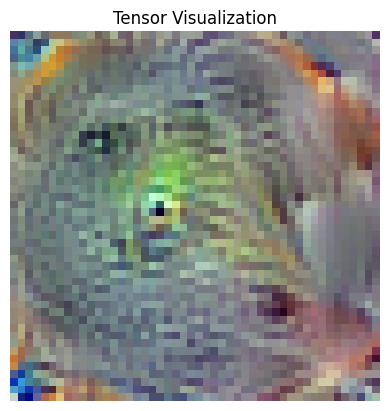

In [12]:
adversarial_patch_2 = torch.rot90(adversarial_patch_1, k=1, dims=(1, 2))
image = adversarial_patch_2.permute(1, 2, 0).numpy()

# Normalize the values to the range [0, 1] for visualization
image = (image - image.min()) / (image.max() - image.min())

# Display the image
plt.imshow(image)
plt.title('Tensor Visualization')
plt.axis('off')  # Remove axis labels
plt.show()

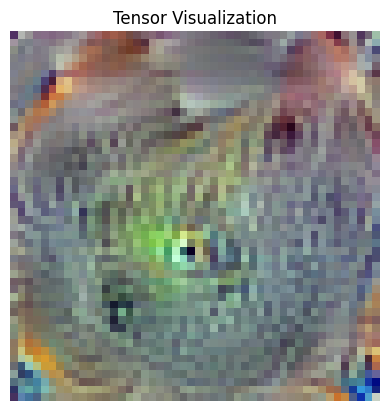

In [14]:
adversarial_patch_3 = torch.rot90(adversarial_patch_2, k=1, dims=(1, 2))
image = adversarial_patch_3.permute(1, 2, 0).numpy()

# Normalize the values to the range [0, 1] for visualization
image = (image - image.min()) / (image.max() - image.min())

# Display the image
plt.imshow(image)
plt.title('Tensor Visualization')
plt.axis('off')  # Remove axis labels
plt.show()

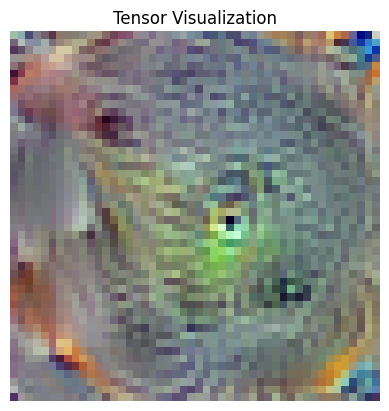

In [15]:
adversarial_patch_4 = torch.rot90(adversarial_patch_3, k=1, dims=(1, 2))
image = adversarial_patch_4.permute(1, 2, 0).numpy()

# Normalize the values to the range [0, 1] for visualization
image = (image - image.min()) / (image.max() - image.min())

# Display the image
plt.imshow(image)
plt.title('Tensor Visualization')
plt.axis('off')  # Remove axis labels
plt.show()

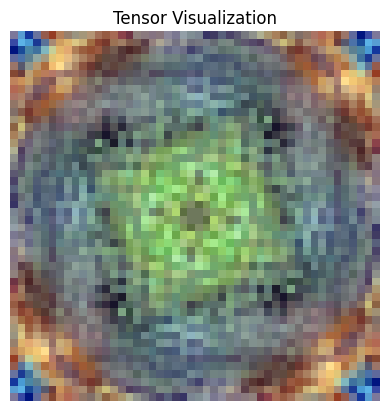

In [18]:
# Add the four versions of adversarial patches
final_adversarial_patch = torch.add(adversarial_patch_1, adversarial_patch_2)
final_adversarial_patch = torch.add(final_adversarial_patch, adversarial_patch_3)
final_adversarial_patch = torch.add(final_adversarial_patch, adversarial_patch_4)

image = final_adversarial_patch.permute(1, 2, 0).numpy()

# Normalize the values to the range [0, 1] for visualization
image = (image - image.min()) / (image.max() - image.min())

# Display the image
plt.imshow(image)
plt.title('Tensor Visualization')
plt.axis('off')  # Remove axis labels
plt.show()